In [63]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import torch.optim as optim
import torch.nn as nn
from PIL import Image
from tqdm import tqdm
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [30]:
base_dir = "CityscapesDataset"

In [31]:
# This block of code is taken from: https://github.molgen.mpg.de/mohomran/cityscapes/blob/master/scripts/helpers/labels.py#L55

from collections import namedtuple

#--------------------------------------------------------------------------------
# Definitions
#--------------------------------------------------------------------------------

# a label and all meta information
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).

    'trainId'     , # An integer ID that overwrites the ID above, when creating ground truth
                    # images for training.
                    # For training, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )


#--------------------------------------------------------------------------------
# A list of all labels
#--------------------------------------------------------------------------------

# Please adapt the train IDs as appropriate for you approach.
# Note that you might want to ignore labels with ID 255 during training.
# Make sure to provide your results using the original IDs and not the training IDs.
# Note that many IDs are ignored in evaluation and thus you never need to predict these!

labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'ground'          , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'ground'          , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'ground'          , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'ground'          , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]

In [32]:
# Create color to trainid mapping
COLOR_TO_TRAINID = {label.color: label.trainId for label in labels if label.trainId != 255}

In [88]:
def find_closest_labels(mask, mapping):
    
    closest_distance = np.full([mask.shape[0], mask.shape[1]], 10000) # Large initial distance
    closest_category = np.full([mask.shape[0], mask.shape[1]], 255) 
    
    # Iterate over every color mapping
    for color, train_id in mapping.items():
        # Ensure color is a NumPy array
        color = np.array(color, dtype=np.int32)

        # Compute Euclidean distance between the mask and the current color in the mapping
        dist = np.linalg.norm(mask - color.reshape(1, 1, 3), axis=-1)

        # Find where the current color is the closest so far
        is_closer = dist < closest_distance

        # Only update where `is_closer` is True
        closest_distance[is_closer] = dist[is_closer]
        closest_category[is_closer] = train_id  # Assign train_id value

    return closest_category

In [89]:
# Create custom dataset class
class CityscapesDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None, target_transform=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.target_transform = target_transform

        # Paths for images and labels
        self.img_dir = os.path.join(root_dir, split, "img")
        self.mask_dir = os.path.join(root_dir, split, "label")

        # List of image files
        self.img_filenames = sorted(os.listdir(self.img_dir))
        self.mask_filenames = sorted(os.listdir(self.mask_dir))

    def __len__(self):
        return len(self.img_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_filenames[idx])

        # Load image and label
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("RGB")

        # Convert mask to class labels using the color mapping
        mask = find_closest_labels(np.array(mask), COLOR_TO_TRAINID)
        # Replace any unknown pixels with 255
        mask[mask == -1] = 255
        
        mask = torch.tensor(mask, dtype=torch.long).unsqueeze(0)

        # Apply transforms
        if self.transform:
            image = self.transform(image)
        else:
            image = transforms.ToTensor()(image) # Ensure image is a tensor
            
        if self.target_transform:
            mask = self.target_transform(mask)

        return image, mask

In [35]:
# Define the dice loss metric
def dice_loss(pred, target, epsilon=1e-6):
    # Apply softmax to get probabilities for each class from the logits
    pred = F.softmax(pred, dim=1)
    num_classes = pred.shape[1]

    # Create mask for valid pixels, ignoring 255
    mask = target != 255

    # Ensure target values are within valid range
    target = torch.clamp(target, 0, num_classes - 1)

    # One-hot encode the target
    target_one_hot = F.one_hot(target.long(), num_classes=pred.shape[1])
    target_one_hot = target_one_hot.permute(0, 3, 1, 2).float()

    # Apply the mask to ignore unlabeled pixels
    pred = pred * mask.unsqueeze(1)
    target_one_hot = target_one_hot * mask.unsqueeze(1)

    # Flatten for batch-wise Dice computation
    pred_flat = pred.view(pred.shape[0], pred.shape[1], -1)
    target_flat = target_one_hot.view(target_one_hot.shape[0], target_one_hot.shape[1], -1)
    
    # Compute the intersection and union
    intersection = torch.sum(pred_flat * target_flat, dim=2)
    union = torch.sum(pred_flat, dim=2) + torch.sum(target_flat, dim=2)

    # Dice coefficient and loss
    dice_score = (2.0 * intersection + epsilon) / (union + epsilon)
    
    return 1 - dice_score.mean() # mean over all classes

In [36]:
# focal loss for multi-class segmentation
def focal_loss(pred, target, alpha=1.0, gamma=2.0):
    cross_entropy_loss = F.cross_entropy(pred, target, reduction='none', ignore_index=255)
    pt = torch.exp(-cross_entropy_loss) # probabilities from CE loss
    focal_loss = alpha * (1 - pt) ** gamma * cross_entropy_loss

    return focal_loss.mean()

In [37]:
# Combined focal loss and dice loss
def combined_loss(pred, target, alpha=1.0, gamma=2.0, dice_weight=1.0, focal_weight=1.0):
    dice = dice_loss(pred, target)
    focal = focal_loss(pred, target, alpha, gamma)

    return dice_weight * dice + focal_weight * focal

In [67]:
# Define transformations. Since the images are pretty small (96x256), random cropping would remove
# too much valuable information. If blurring the image, a smaller kernel should be applied. Color jitter
# should be applied conservatively to avoid excessive distortion. Scaling also should be limited since 
# the images are small.
train_image_transform = transforms.Compose([
    transforms.Resize((96, 256)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),  # Color jitter
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_label_transform = transforms.Compose([
    transforms.Resize((96, 256))  
])

val_image_transform = transforms.Compose([
    transforms.Resize((96, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_label_transform = transforms.Compose([
    transforms.Resize((96, 256))
])

In [90]:
# Create CityscapesDataset objects for the training and validation datasets
train_dataset = CityscapesDataset(
    root_dir=base_dir,
    split="train",
    transform=train_image_transform,
    target_transform=train_label_transform)

val_dataset = CityscapesDataset(
    root_dir=base_dir,
    split="val",
    transform=val_image_transform,
    target_transform=val_label_transform)

In [59]:
def denormalize(image, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    mean = torch.tensor(mean).view(3, 1, 1)  # Reshape to (C,1,1) for broadcasting
    std = torch.tensor(std).view(3, 1, 1)
    return image * std + mean  # Reverse normalization

In [101]:
def create_cityscapes_colormap(mapping):
    num_classes = max(mapping.values()) + 1
    colormap = np.zeros((num_classes, 3), dtype=np.uint8) # Initialize empty colormap

    for color, train_id in mapping.items():
        colormap[train_id] = np.array(color) # Assign color to correct index

    return colormap / 255.0

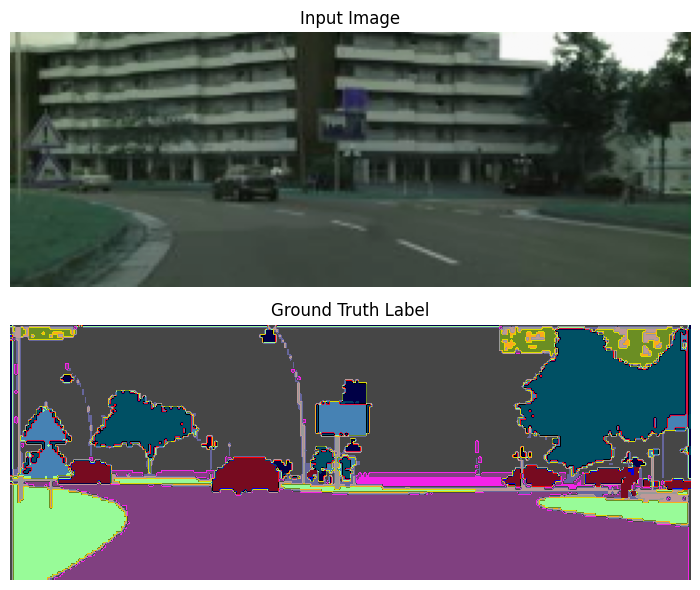

In [102]:
# Get a single sample from the training dataset
image, mask = train_dataset[0]  # Change index to visualize a different sample

# Ensure image is in (C, H, W) format for denormalization
image = denormalize(image)  # Apply denormalization
image_np = image.cpu().numpy().transpose(1, 2, 0)  # Convert to (H, W, C) for imshow
image_np = image_np.clip(0, 1)  # Clip values to valid range for imshow

# Convert mask tensor to NumPy
mask_np = mask.squeeze(0).cpu().numpy()  # Convert shape (1, H, W) → (H, W)

# Generate the colormap from Cityscapes labels
cityscapes_cmap = create_cityscapes_colormap(COLOR_TO_TRAINID)
custom_cmap = mcolors.ListedColormap(cityscapes_cmap)

# Plot the image and label
fig, axes = plt.subplots(2, 1, figsize=(8, 6))

axes[0].imshow(image_np)
axes[0].set_title("Input Image")
axes[0].axis("off")

axes[1].imshow(mask_np, cmap=custom_cmap, vmin=0, vmax=len(cityscapes_cmap) - 1)
axes[1].set_title("Ground Truth Label")
axes[1].axis("off")

plt.tight_layout()
plt.show()

In [98]:
# Load the DeepLabV3 model with the ResNet50 backbone
model = deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.DEFAULT)

# Modify the model's final layer for the Cityscapes dataset
num_classes = len(COLOR_TO_TRAINID)
model.classifier[4] = torch.nn.Conv2d(256, num_classes, kernel_size=1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [41]:
# Define learning rate scheduler with warmup
def get_linear_warmup_scheduler(optimizer, base_lr, num_epochs, num_warmup=3):
    def lr_lambda(epoch):
        return min(1.0, (epoch+1) / num_warmup)

    return lr_scheduler.LambdaLR(optimizer, lr_lambda)

In [100]:
# Define hyperparameters
# criterion = nn.CrossEntropyLoss(ignore_index=255) # pixels with 255 not included in loss
criterion = lambda pred, target: combined_loss(pred, target, dice_weight=1.25, focal_weight=1.0)
batch_size = 32
learning_rate = 0.0005
decay = 0.001
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=decay)
num_epochs = 10
scheduler = get_linear_warmup_scheduler(optimizer, learning_rate, num_epochs)

best_model_path = "best_model.pth" # Path to save the best model based on validation loss

In [47]:
# Create dataloaders for the training and validation datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [48]:
def train_model(model, train_loader, val_loader, num_epochs, optimizer, scheduler):
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        print(f"Epoch {epoch+1}: LR = {scheduler.get_last_lr()[0]:.6f}")

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)['out'] # DeepLabV3 outputs a dict with 'out'
            
            loss = criterion(outputs, masks.squeeze(1).long())
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.4f}")

        # Switch to eval for validation
        model.eval()
        
        with torch.no_grad():
            val_loss = 0

            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)['out']
                loss = criterion(outputs, masks.squeeze(1).long())
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        print(f"Validation Loss: {avg_val_loss:.4f}")

        # Save the model if the validation loss has improved
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), best_model_path)
            print(f"New best model saved with validation loss: {best_val_loss:.4f}")

        # Step the learning rate scheduler
        scheduler.step()

In [49]:
train_model(model, train_loader, val_loader, num_epochs, optimizer, scheduler)

Epoch 1: LR = 0.000167
Epoch [1/1], Train Loss: 2.4654
Validation Loss: 1.9702
New best model saved with validation loss: 1.9702


In [50]:
# Load best performing model
model.load_state_dict(torch.load(best_model_path, weights_only=True))
model.eval()

# Evaluate on validation set
dice_scores = []

with torch.no_grad():
    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)['out']

        # Compute dice score
        dice = dice_loss(outputs, masks.squeeze(1).long())
        dice_scores.append(dice)

print("Average dice score for val set:", np.mean(dice_scores))

Average dice score for val set: 0.9256071


In [74]:
def denormalize_val(image, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    image = image.permute(1, 2, 0).cpu().numpy()  # Convert to HWC format
    image = image * np.array(std) + np.array(mean)  # Reverse normalization
    image = np.clip(image, 0, 1)  # Ensure values are in valid range
    return image

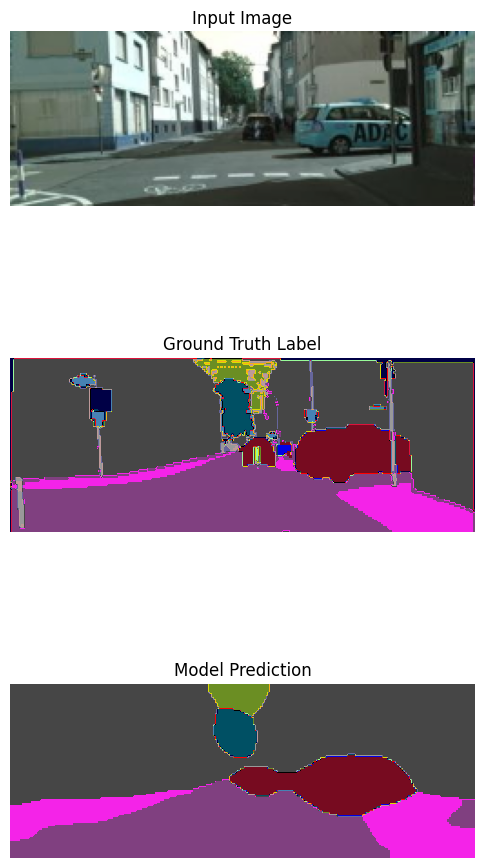

In [82]:
# Get random sample from val set
images, labels = next(iter(val_loader))
images, labels = images.to(device), labels.to(device)
outputs = model(images)['out']

# Convert prediction to mask
pred_mask = torch.argmax(outputs, dim=1).squeeze(0).cpu().numpy().astype(np.uint8)

# Visualize a sample
fig, axes = plt.subplots(3, 1, figsize=(6, 12))

# Denormalize and clip image for visualization
axes[0].imshow(denormalize_val(images[0]))
axes[0].set_title("Input Image")
axes[0].axis("off")

# Convert label and prediction to uint8 for proper visualization
# axes[1].imshow(labels[0], cmap=custom_cmap, vmin=0, vmax=len(cityscapes_cmap) - 1)

axes[1].imshow(labels[0].squeeze(0).cpu().numpy().astype(np.uint8), cmap=custom_cmap, vmin=0, vmax=len(cityscapes_cmap) - 1)
axes[1].set_title("Ground Truth Label")
axes[1].axis("off")

axes[2].imshow(pred_mask[0], cmap=custom_cmap, vmin=0, vmax=len(cityscapes_cmap) - 1)
axes[2].set_title("Model Prediction")
axes[2].axis("off")

plt.show()